# WATER BAG CLUSTERS IN RIO DE JANEIRO - FINAL MODELS

---
### Notebook Sections:

1. Utility functions
1. Data Cleaning
3. Final Cluster Model
4. Clusters' Numeric and Geometric Properties
5. Clusters' Result Analysis

### Import modules and functions

In [1]:
import os, sys, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Change project root folder

In [2]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


### Load data

In [3]:
catalog = pd.read_csv('Dados/Catalog/water_bag_catalog_google.csv'); data = catalog.copy()
data[['EVENTO_ID', 'EVENTO_TITULO', 'EVENTO_DESCRICAO', 'EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'EVENTO_INICIO']].head()

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_LATITUDE,EVENTO_LONGITUDE,EVENTO_INICIO
0,1258,Bolsão d'agua,R. Pinheiro Machado com Muniz Barreto - Botafogo,-22.944774,-43.183917,2015-09-12 20:12:00
1,1259,Bolsão,"Av. Novo Rio, 3131 - Bonsucesso",-22.871684,-43.256200,2015-09-12 22:13:00
2,1260,Bolsão,"Av. Ataulfo de Paiva, 752 - Leblon",-22.984337,-43.223100,2015-09-12 22:15:00
3,1261,Bolsão,Avenida General San Martin / Praça Antero de Q...,-22.984337,-43.223100,2015-09-12 22:16:00
4,1263,Bolsão d'água,"Av. Brasil, 40 - São Cristóvão",-22.892179,-43.216400,2015-09-13 06:30:00


---
## 0. Utility functions

#### Functions to format and correct street number text variable

In [4]:
from Modulos.text_formatter import text_transform_pipeline, get_not_number, drop_letters, drop_space, drop_chars, split_avg

#### Unsupervised learning algorithms, evaluation metrics and preprocessing functions

In [5]:
from sklearn import cluster, mixture, metrics
from sklearn.preprocessing import MinMaxScaler as mms, LabelEncoder as le

#### Plot colored and connected coordinates in 2D plane

In [6]:
from Modulos.coord_plot import (
    cmaps, filter_group_size,
    cluster_algo_comparison,
    connect_coordinates_colored,
    min_group_size_progression_plot,
    atemporal_evolution_plot
)

#### Cluster hyperparameter tunning module

In [7]:
from Modulos.cluster_tunning import (
    labels_size_stats,
    log_range,
    cluster_grid_search,
    evaluate_labels,
    min_samples_analysis,
    rotate_3d_plot
)

---
# 1. Data Cleaning

#### Format and correct street number variable

In [8]:
not_number = get_not_number(catalog['street_number'])
not_number_corrected =  text_transform_pipeline(not_number, [drop_letters, drop_space, drop_chars, split_avg])

data.loc[not_number.index, ['street_number']] = not_number_corrected

#### Data type conversion

In [9]:
float_cols = ['EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'search_lat', 'search_lng', 'street_number']
data[float_cols] = data[float_cols].astype(float)

---
# 4. Final Water Bag Coordinates Cluster Model

### Scale algorithm input data

In [10]:
profile_cols = ['EVENTO_LONGITUDE', 'EVENTO_LATITUDE']
coords = pd.DataFrame(mms().fit_transform(data[profile_cols]), columns=profile_cols, index=data.index)

### Fit model of selected hyperparameters

In [11]:
bandwidth = 0.01 # 0.01 and 0.05 for macro and micro clusters

alg = meanshift = cluster.MeanShift(
    bandwidth=bandwidth, cluster_all=False,
    max_iter=1000, n_jobs=-1
)

alg.fit(coords)

MeanShift(bandwidth=0.01, cluster_all=False, max_iter=1000, n_jobs=-1)

### Choose number of clusters/samples left

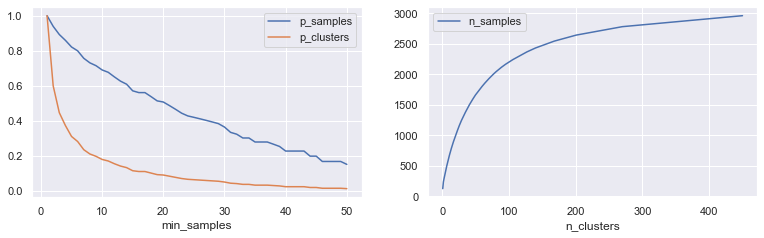

In [12]:
size_stats = labels_size_stats(alg.labels_, max_samples=None)

fig, ax = plt.subplots(1, 2, figsize=(13, 3.5))
size_stats[['p_samples', 'p_clusters']].head(50).plot(ax=ax[0])
size_stats.set_index('n_clusters')[['n_samples']].plot(ax=ax[1])
plt.show()

### Filter cluster result:
1. Remove outliers
2. Remove clusters with less than 'min_samples'

In [13]:
min_samples = 8

data['label'] = alg.labels_
in_data = data[data['label'] != -1]
top_data = filter_group_size(in_data, group_col='label', min_members=min_samples) # Excluing clusters with less then 'min_members' samples 

# Create new label column 
outlabels = list(set(data['label']).difference(top_data['label']))
data['sublabel'] = data['label'].replace(outlabels, -1)

in_data = data[data['sublabel'] != -1]
top_data['sublabel'] = top_data['label']  # Since it already does not contain samples from clusters smallest than 'min_members'

print('Samples left:', len(top_data))
print('Clusters left:', len(top_data['sublabel'].unique())); print()
print('Samples left (%):', round(100 * len(top_data) / (data['label'] != -1).sum(), 1), '%')
print('Clusters left (%):', round(100 * len(top_data['sublabel'].unique()) / (len(data['label'].unique()) - 1), 1), '%')

Samples left: 2118
Clusters left: 89

Samples left (%): 71.5 %
Clusters left (%): 19.8 %


### Scatter clusters on 2D plane

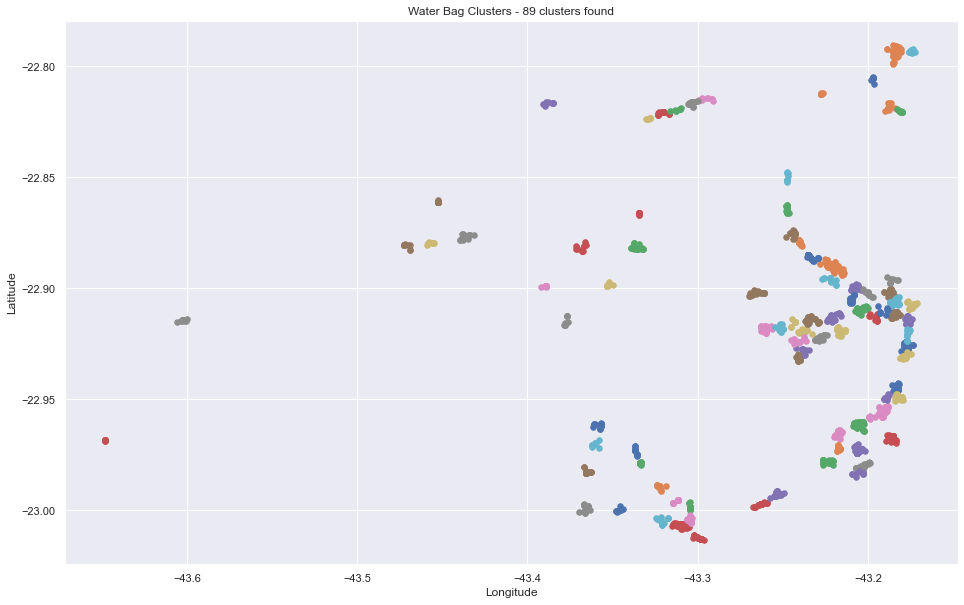

In [14]:
connect_coordinates_colored(
    top_data['EVENTO_LONGITUDE'], top_data['EVENTO_LATITUDE'],
    top_data['label'], top_data['street_number'], cmap=None,
    title='Water Bag Clusters - {} clusters found',
    figsize=(16, 10), connect=False
)

### Include clusters' geometric propeties and address info

In [15]:
from Modulos.group_methods import groups_majority_class, group_majority_class_numeric_range
from Modulos.geometric_properties import clusters_geometry

clusters = data.set_index('EVENTO_ID')[['sublabel']]

# Join clusters' representative  neighborhood, route and street number range
clusters['main_neighborhood'] = groups_majority_class(data, group_col='sublabel', class_col='EVENTO_BAIRRO')
clusters['main_route'] = groups_majority_class(data, group_col='sublabel', class_col='route')
clusters['main_street_number_range'] = group_majority_class_numeric_range(data, group_col='sublabel', class_col='route', num_col='street_number')

# Join geometric properties
geometry = clusters_geometry(
    data['EVENTO_LATITUDE'], data['EVENTO_LONGITUDE'], clusters['sublabel'],
    include_box=True, include_center_radius=True
)
clusters = clusters.join(geometry)

### Save and reload best cluster result

Cluster info:
1. Label
2. Incidents Count
2. Representative neighborhood, street and number range
3. Centroid
4. Box geometry
4. Circle geometry
5. Box and circle Incident Density

In [10]:
# clusters.to_csv('Dados/Clusters/clusters_bolsões_macro.csv', index=True)
clusters = pd.read_csv('Dados/Clusters/clusters_bolsões_micro.csv', index_col=0)

display(clusters.head(3), clusters.shape)

,sublabel,main_neighborhood,main_route,main_street_number_range,lat_centroid,lng_centroid,label_count,lat_min,lat_max,lng_min,lng_max,lat_center,lng_center,horizontal_perimeter,vertical_perimeter,radius,area_box,area_circle,density_box,density_circle
EVENTO_ID,,,,,,,,,,,,,,,,,,,,
1258,9,Botafogo,Praia de Botafogo,360 - 314,-22.945530,-43.183139,28,-22.946042,-22.944774,-43.184100,-43.182102,-22.945408,-43.183101,140.433511,204.942823,102.471412,2.878084e+04,3.298795e+04,0.000973,8.487948e-04
1259,-1,Barra da Tijuca,Avenida Brasil,35025 - 14,-22.910743,-43.303404,1624,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964,1.595277e+09,2.279703e+09,0.000001,7.123734e-07
1260,-1,Barra da Tijuca,Avenida Brasil,35025 - 14,-22.910743,-43.303404,1624,-23.031019,-22.763640,-43.692051,-43.166944,-22.897329,-43.429498,29610.228706,53875.861927,26937.930964,1.595277e+09,2.279703e+09,0.000001,7.123734e-07


(3140, 20)

### Extract cluster dataset - Clusters as rows

In [ ]:
# Extract geometry dataset of clusters as rows
areas = clusters.groupby('sublabel').first()

# Convert units
areas['radius'] = areas['radius'] * 1e-3                  # m -> Km
areas['area_box'] = areas['area_box'] * 1e-6              # m2 -> Km2
areas['area_circle'] = areas['area_circle'] * 1e-6        # m2 -> Km2
areas['density_box'] = areas['density_box'] * 1e6         # /m2 -> /Km2
areas['density_circle'] = areas['density_circle'] * 1e6   # /m2 -> /Km2

# Format title for plotting tooltips
areas['title'] = (
    areas['main_route'] +
    ', ' +
    areas['main_street_number_range'] +
    '.  Incidents: ' +
    areas['label_count'].astype(str) +
    ',  Area: ' +
    (areas['area_box']).round(3).astype(str) +
    ' Km2,  Density: ' +
    (areas['density_box']).round(2).astype(str) +
    ' / 100 m2'
)

#### Save and reload clusters dataset

In [11]:
# areas.to_csv('Dados/Clusters/clusters_micro.csv', index=True)
areas = pd.read_csv('Dados/Clusters/clusters_micro.csv', index_col=0); display(areas.iloc[:5, :-10], areas.shape)

,main_neighborhood,main_route,main_street_number_range,lat_centroid,lng_centroid,label_count,lat_min,lat_max,lng_min,lng_max
sublabel,,,,,,,,,,
-1,Barra da Tijuca,Avenida Brasil,35025 - 14,-22.910743,-43.303404,1624,-23.031019,-22.763640,-43.692051,-43.166944
0,Barra da Tijuca,Avenida Armando Lombardi,3098 - 67,-23.006631,-43.310232,114,-23.007133,-23.006231,-43.312829,-43.308183
1,Catete,Rua do Catete,228 - 139,-22.926423,-43.176842,99,-22.927198,-22.925534,-43.178604,-43.175549
2,Copacabana,Rua Tonelero,236 - 9,-22.966793,-43.185999,43,-22.967739,-22.966181,-43.187500,-43.185232
3,Ipanema,Avenida Epitácio Pessoa,1910 - 1602,-22.979735,-43.202540,36,-22.980438,-22.979236,-43.204100,-43.201200


(80, 20)

### Scatter clusters on terrain map

#### Terrain map with clusters surrounded by boxes or circles

In [12]:
data['sublabel'] = clusters.loc[data['EVENTO_ID']]['sublabel'].values

In [13]:
from Modulos.mapper import plot_markers, draw_circles, draw_rectangles
import folium

Map = folium.Map(
    location=[-22.9145, -43.2105], zoom_start=14,
    width='100%', height='100%', tiles='Stamen Terrain'
)

Map, LE = plot_markers(
    Map, data, radius=3,
    coord_cols=['EVENTO_LATITUDE', 'EVENTO_LONGITUDE'],
    group_col='sublabel', cmap='tab20',
    exclude=[], touch_coord=True, return_encoder=True
)

Map = draw_rectangles(
    Map, areas.drop(-1),
    loc=[['lat_min', 'lng_min'], ['lat_max', 'lng_max']],
    popup='main_neighborhood', tooltip='title',
    cmap='tab20', lut=len(areas), LE=LE,
    stroke=True, weight=3, fill=True,
    fill_color=None, fill_opacity=.3
)

# Map = draw_circles(
#     Map, areas,
#     loc=['lat_center', 'lng_center'], radius='radius',
#     popup='main_route', tooltip='main_route',
#     cmap='tab20', lut=len(areas), LE=LE,
#     stroke=True, weight=4, fill=True,
#     fill_color=None, fill_opacity=.3
# )

Map

## Save map to html

In [50]:
Map.save('bolsoes_clusters_micro.html')

---
# 5. Final Model Result Analysis

### Number of clusters extracted

In [19]:
len(areas) - 1

89

### Number of events left in clusters

In [20]:
(clusters['sublabel'] != -1).mean()

0.6745222929936305

### Top regions by historical incident count and routes per cluster histogram

c:\Users\luisr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


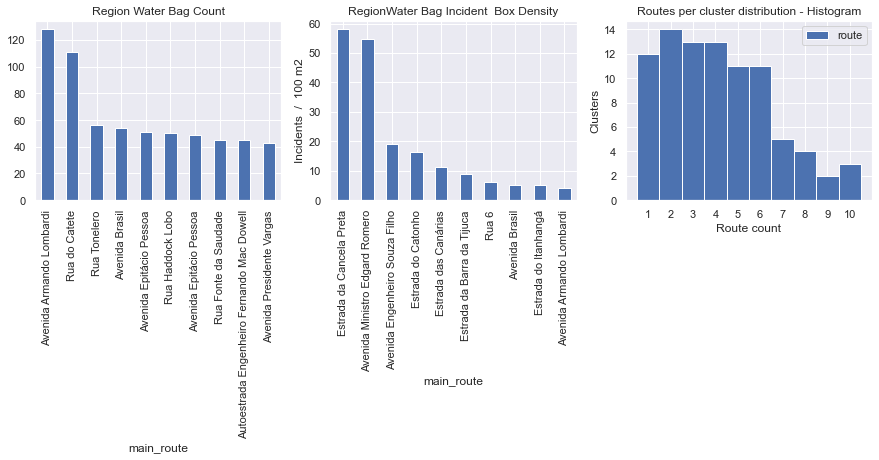

In [21]:
top_dense = areas.sort_values('density_box').iloc[-1].name # incident density outlier

fig, axes = plt.subplots(1, 3, figsize=(15, 3.3), tight_layout=True)

#### Top clusters by historical incident count
areas.drop(-1).set_index('main_route')['label_count'].nlargest(10).plot.bar(
    title='Region Water Bag Count', ax=axes[0]
)
#### Top clusters by historical incident density
ax = (areas.drop([-1, top_dense]).set_index('main_route')['density_box'].nlargest(10) * 1e-2).plot.bar(
    title='RegionWater Bag Incident  Box Density', ax=axes[1]
)
axes[1].set(ylabel='Incidents  /  100 m2')

#### Routes per cluster distribution
bins = np.linspace(0.5, 10.5, 11)
xticks=np.linspace(1, 10, 10)
top_data.groupby(['sublabel'])[['route']].nunique().sort_values('route', ascending=False).plot.hist(
    bins=bins, xticks=xticks, ax=axes[2]
)
axes[2].set(title='Routes per cluster distribution - Histogram', ylabel='Clusters', xlabel='Route count')

plt.show()

### Cluster size distribution

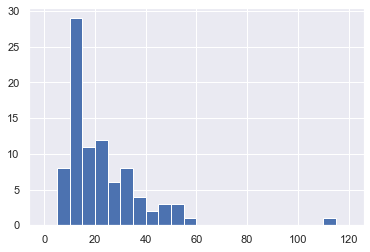

In [22]:
areas.drop(-1).set_index('main_route')['label_count'].hist(bins=np.arange(0, 121, 5))

### Numeric variables statistical description

In [23]:
numeric_cols = ['label_count', 'radius', 'area_box', 'area_circle', 'density_box', 'density_circle']

areas[numeric_cols].describe().drop('count')

,label_count,radius,area_box,area_circle,density_box,density_circle
mean,34.888889,0.575093,17.899093,25.605077,846.206795,231.850914
std,106.906811,2.812024,168.138421,240.272587,4967.732464,646.966595
min,9.000000,0.023583,0.000192,0.001747,0.640641,0.448304
25%,12.000000,0.212086,0.099617,0.141312,74.543291,49.545039
50%,18.000000,0.284044,0.178001,0.253466,124.976097,77.404289
75%,30.000000,0.351936,0.256449,0.389122,223.845875,165.437196
max,1022.000000,26.937931,1595.276593,2279.703384,46753.366995,5151.104120


### Numeric variables distribution and relationship

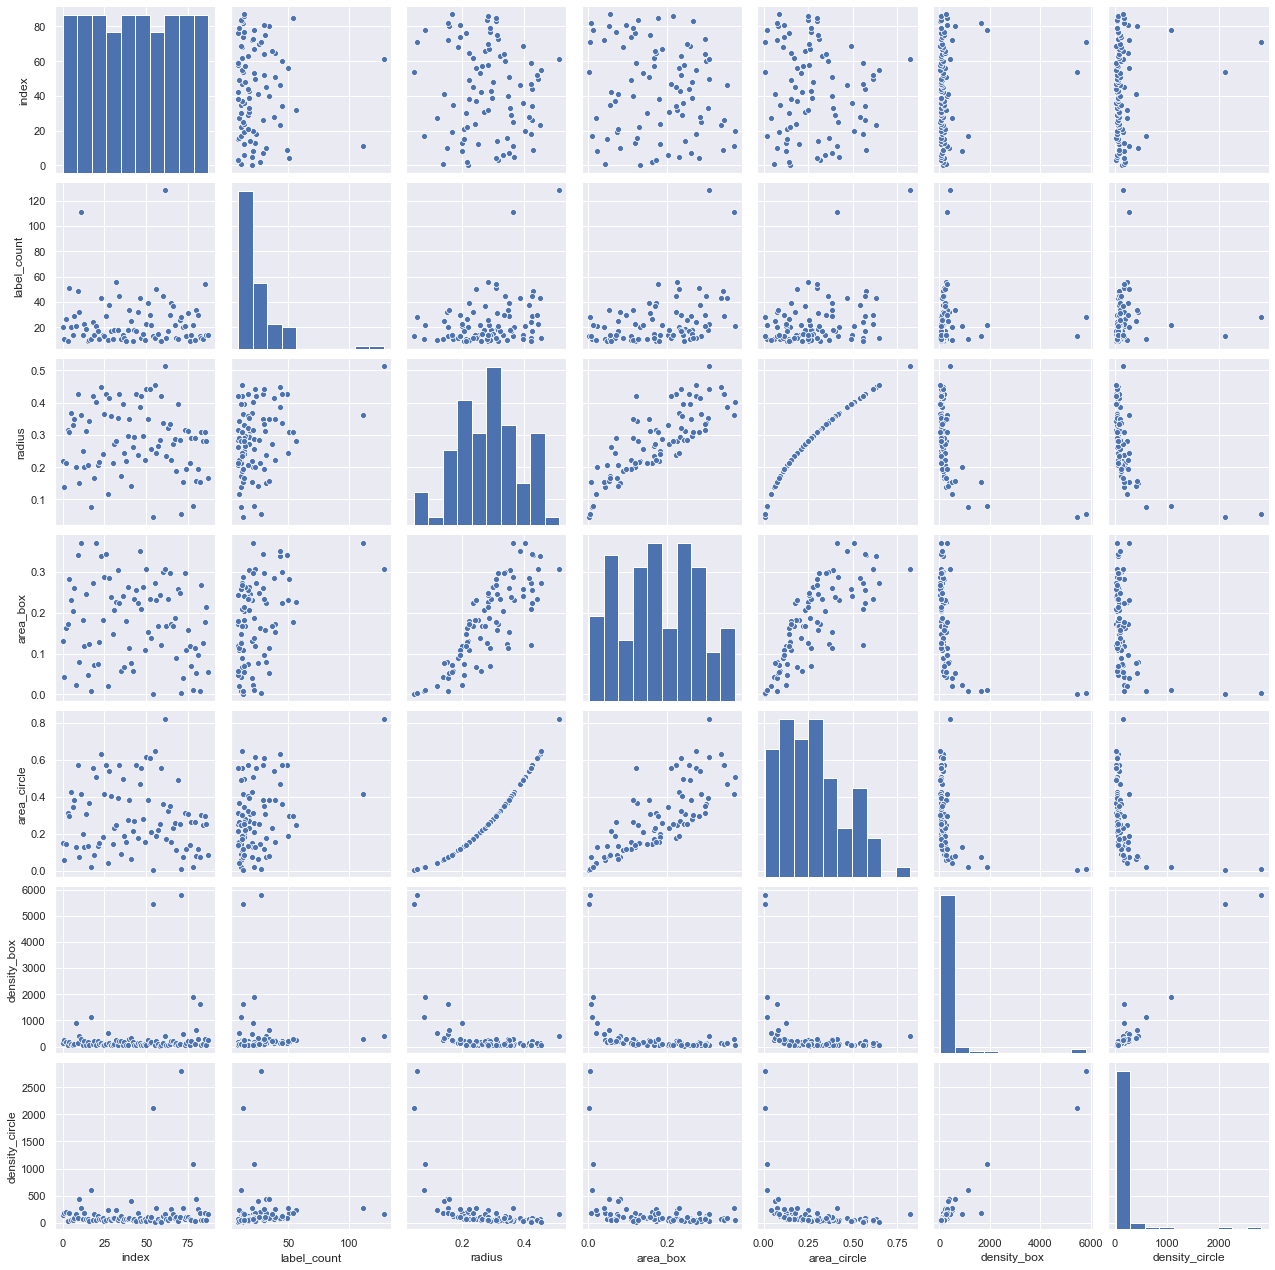

In [24]:
formatted_areas = areas.drop([-1, top_dense])[numeric_cols].sample(frac=1).reset_index(drop=True).reset_index(drop=False)
ax = sns.pairplot(formatted_areas)

### Numeric variables boxplots

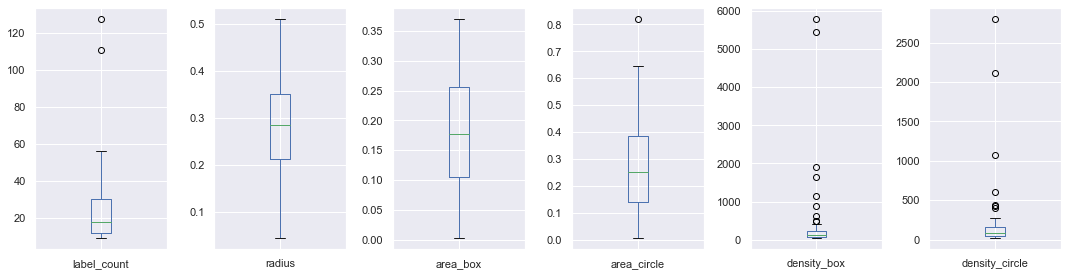

In [25]:
fig, axes = plt.subplots(1, 6, figsize=(15, 4), tight_layout=True)
ax = areas.drop([-1, top_dense])[numeric_cols].plot.box(subplots=(3,3), ax=axes)
plt.show()